In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt 
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm import *
import torch
import random
sys.path.append('../esa')
from esa.load_utils import *
from esa.lstm_utils import *

from omegaconf import OmegaConf
from notebook_utils import launch_train_advice

import numpy as np
%matplotlib inline

architecture = 'lstm'
os.environ['architecture'] = architecture
config_file = os.path.join(conf_path, architecture+'.yaml')
cfg = OmegaConf.load(config_file)
cfg.dataset.out_window = cfg.dataset.sequence_length

In [2]:
if os.path.exists(model_results+ '{}/'.format(architecture)):
    model_list = os.listdir(model_results+ '{}/'.format(architecture))
    for ix, mn in enumerate(model_list):  
        print('model num {}: {}'.format(ix,model_list[ix]))
else:
    os.makedirs(model_results+ '{}/'.format(architecture))
    model_list = []

model num 0: lstm_sl_16_emb_64_layers_1_1_24_04_2023_10:45:35.pth
model num 1: lstm_sl_16_emb_64_layers_1_1_24_04_2023_12:47:16.pth
model num 2: lstm_sl_16_emb_64_layers_1_1_23_04_2023_11:15:55.pth


In [3]:
launch_train_advice(cfg, model_list, config_file)

to train a model  switch train_model to True  in the next cell
to train a new model from scratch set train_model to True in the next cell

check the configuration file in /home/rob/Documents/repo/esa_fdir/time_series_anomaly_detection/configuration/lstm.yaml to set the hyperparameters of the model

actual dataset configuration is {'name': 'all_2016-2018_clean_std_4s.pkl', 'sequence_length': 16, 'perc_overlap': 1, 'columns': ['RW1_motcurr', 'RW2_motcurr', 'RW3_motcurr', 'RW4_motcurr', 'RW1_cmd_volt', 'RW2_cmd_volt', 'RW3_cmd_volt', 'RW4_cmd_volt', 'RW1_therm', 'RW2_therm', 'RW3_therm', 'RW4_therm', 'RW1_speed', 'RW2_speed', 'RW3_speed', 'RW4_speed'], 'train_val_split': 0.7, 'shuffle': 0, 'columns_subset': 0, 'dataset_subset': 1000000, 'batch_size': 500, 'sampling_rate': '4s', 'scaled': 1, 'target': None, 'forecast': 0, 'forecast_all': 1, 'predict': 0, 'out_window': 16}

actual architecture configuration is {'architecture': 'lstm', 'embedding_dim': 64, 'latent_dim': 100, 'n_layers_1': 1,

In [4]:
train_model = False

In [5]:
if train_model:
    %run ../main.py --config_name $architecture

In [6]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
if len(model_list) > 0:
    model_list = os.listdir(model_results+ '{}/'.format(architecture))
    for ix, mn in enumerate(model_list):  
        print('model num {}: {}'.format(ix,model_list[ix]))
    model_available = True
else:
    print('no model available')

model num 0: lstm_sl_16_emb_64_layers_1_1_24_04_2023_10:45:35.pth
model num 1: lstm_sl_16_emb_64_layers_1_1_24_04_2023_12:47:16.pth
model num 2: lstm_sl_16_emb_64_layers_1_1_23_04_2023_11:15:55.pth


In [7]:
selected_model = 1
if model_available:
    print(model_list[selected_model])
    model_name = model_list[selected_model].split('.')[0]
else:
    print('no model available')

lstm_sl_16_emb_64_layers_1_1_24_04_2023_12:47:16.pth


In [8]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    sm = 'sm_' + sm
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [9]:
checkpoint  = torch.load(model_results+ '{}/'.format(architecture) + '/' + model_list[selected_model])
params_conf = checkpoint['param_conf']

In [10]:
cols = params_conf['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']

out_window = params_conf['out_window']

latent_dim = params_conf['latent_dim']
seq_len = params_conf['sequence_length']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

try:
    no_latent = params_conf['no_latent']
except:
    no_latent = False
shuffle = False

data_path = params_conf['data_path']

In [11]:
dataset_name = os.path.join(data_path, "all_2016-2018_clean_std_4s.pkl")
transform = None

#test=False

df_train, df_test, train_iter, test_iter, test_iter_loss = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=params_conf['columns'],
columns_subset=params_conf['columns_subset'], dataset_subset=params_conf['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=params_conf['train_val_split'], batch_size=params_conf['batch_size'], 
             transform=transform)

In [12]:
model = LSTM(seq_in=params_conf['sequence_length'], seq_out= params_conf['out_window']
              , n_features=params_conf['n_features'],
            output_size=len(params_conf['target']), embedding_dim=params_conf['embedding_dim'],
            n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
par_nums=count_parameters(model)
print('parameters number', par_nums)
model.to(device).eval()

Encoder(
  (LSTMenc): LSTM(16, 128, batch_first=True)
  (LSTM1): LSTM(128, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=16, bias=True)
)
parameters number 125456


LSTM(
  (encoder): Encoder(
    (LSTMenc): LSTM(16, 128, batch_first=True)
    (LSTM1): LSTM(128, 64, batch_first=True)
    (out): Linear(in_features=64, out_features=16, bias=True)
  )
)

In [13]:
compute_mse_val_loss = False

In [18]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter_loss):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
        print(mse_val_loss_list[-1])
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)

In [19]:
num_batch = 10
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches(num_batch=num_batch, test_iter=test_iter, 
                     sequence_length=params_conf['sequence_length'], cols=params_conf['columns']
                             , shift = None)

time horizon 160
random shift 57208


In [20]:
yo = model(x.to(device))

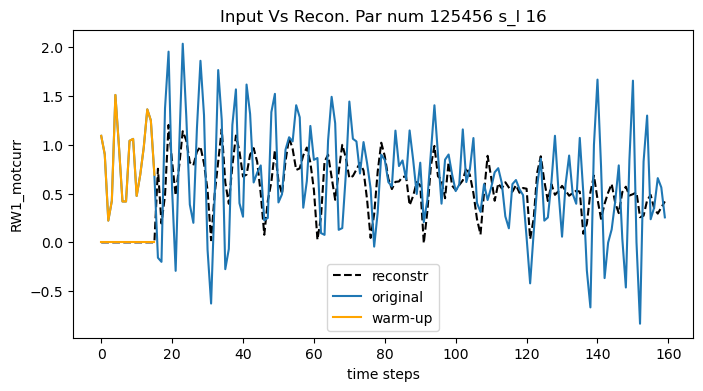

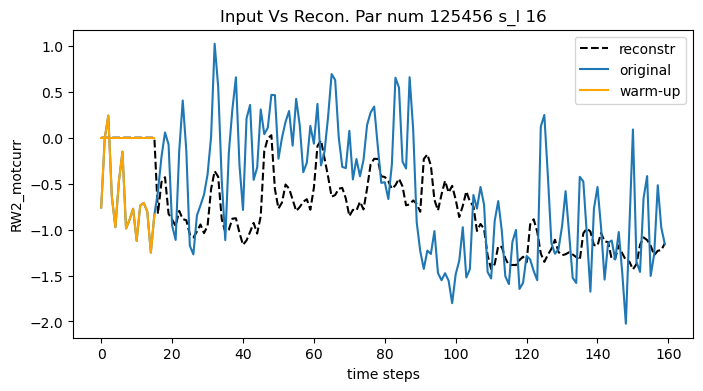

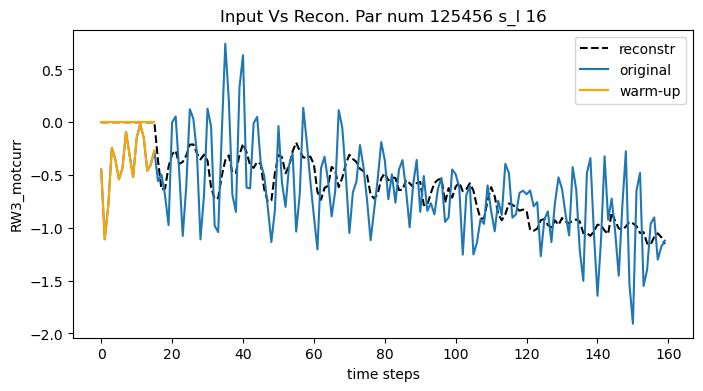

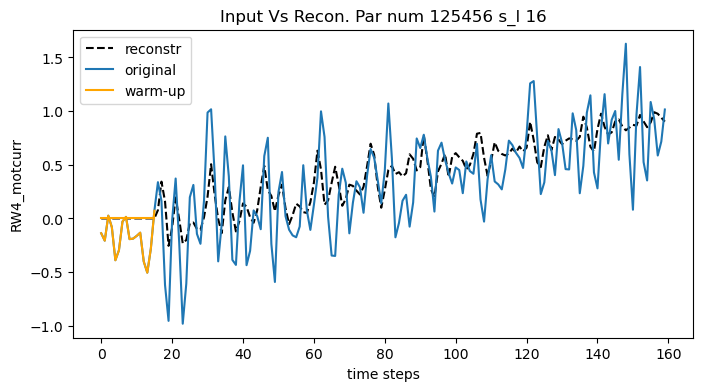

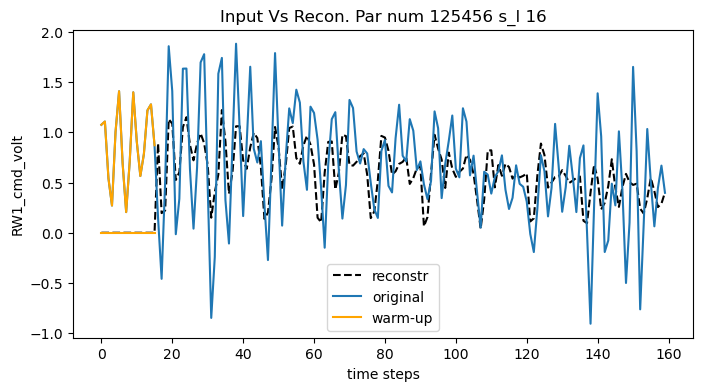

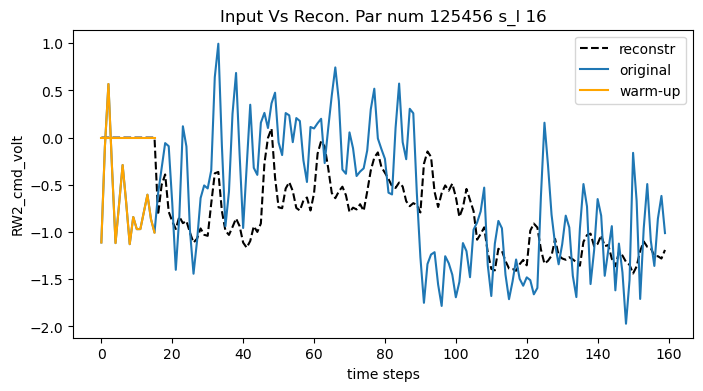

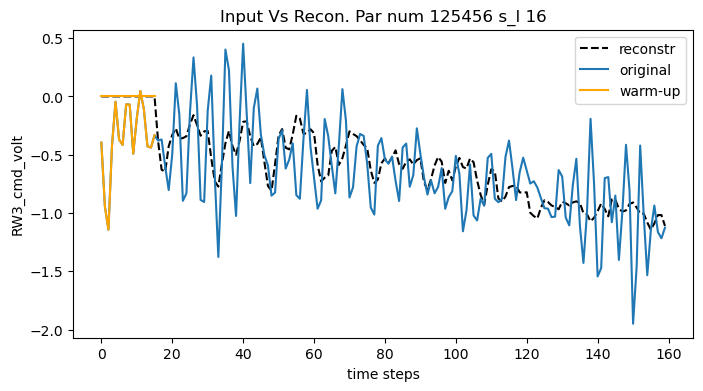

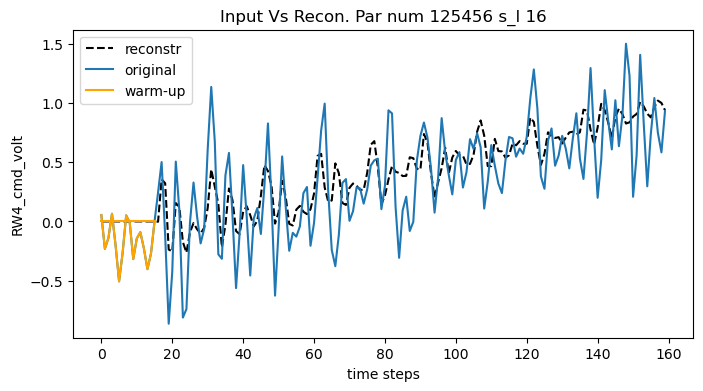

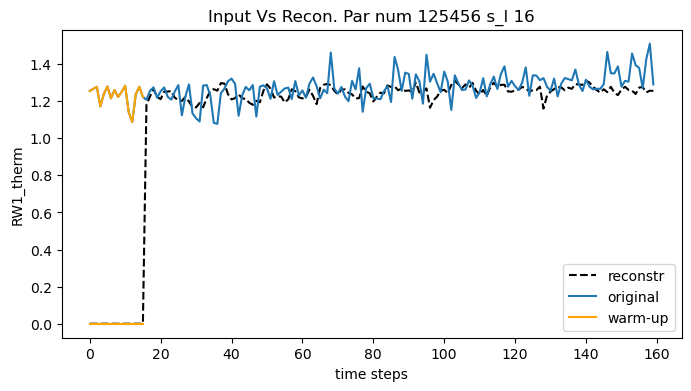

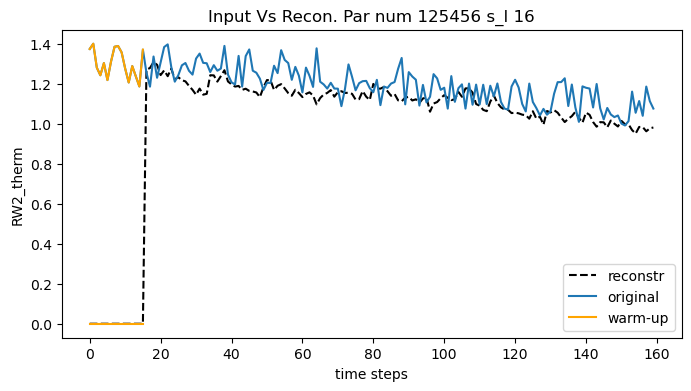

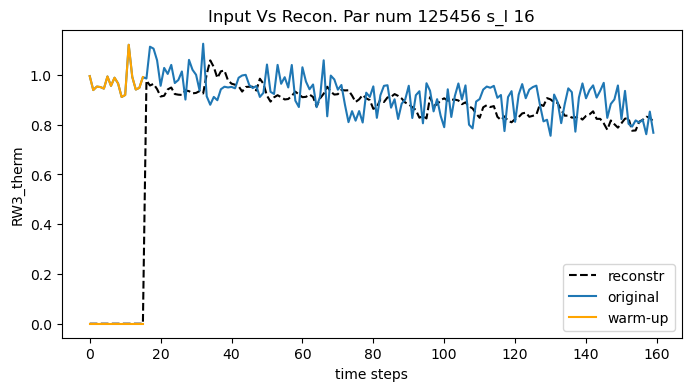

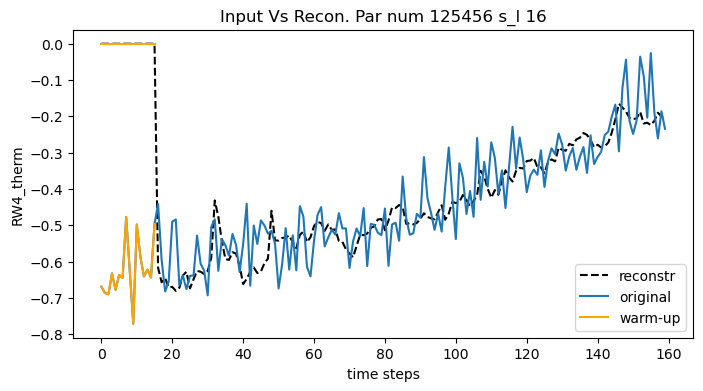

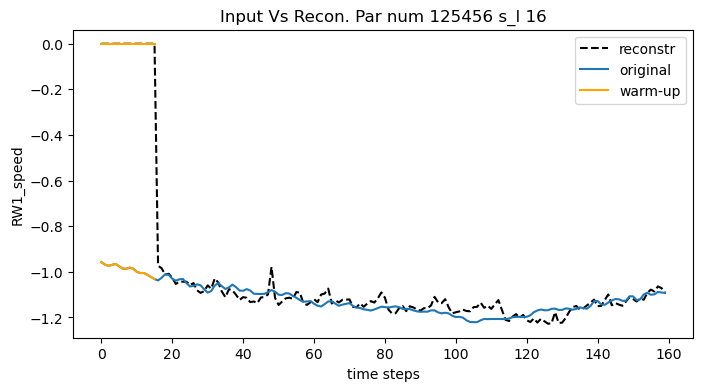

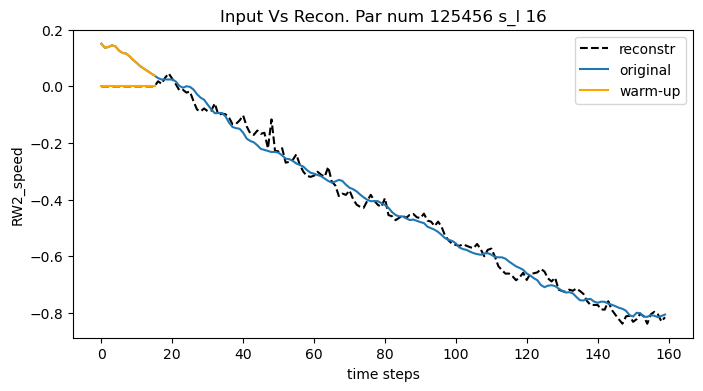

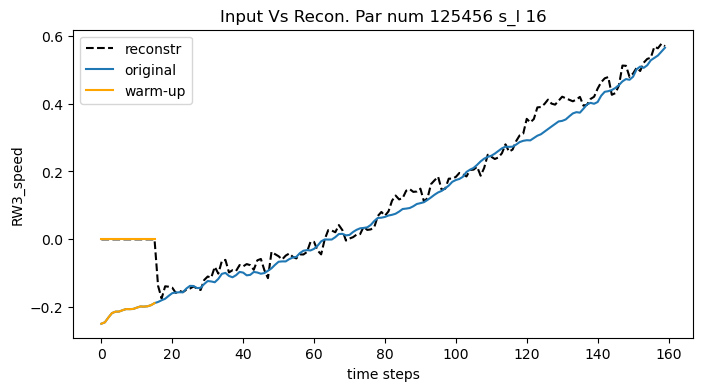

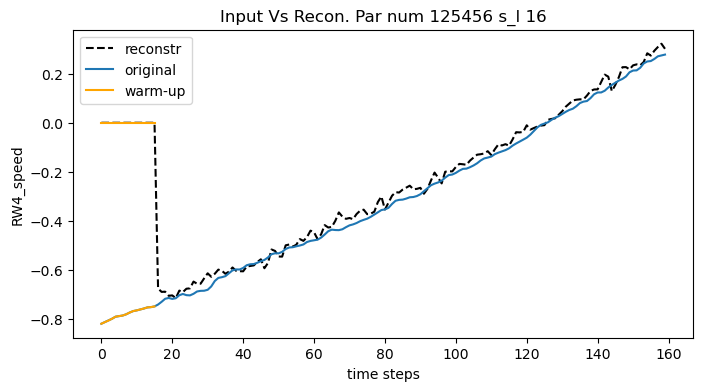

In [21]:
show_results(x.to(device),yo,params_conf['columns'],
    model_name,params_conf,par_nums,shift,
    num_batch,architecture='lstm',
    save=False)